## Human p53 network - REGGaE

In [7]:
## TensorFlow SETUP
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
from tensorflow import math as tfm

from timeit import default_timer as timer
from datetime import datetime
from IPython.display import display
import matplotlib.pyplot as plt

from reggae.data_loaders import load_barenco_puma, DataHolder, load_humanp53
from reggae.mcmc import create_chains, MetropolisHastings, Parameter
from reggae.utilities import discretise, logit, logistic, LogisticNormal, inverse_positivity
from reggae.plot import mcmc_plotters
from reggae.mcmc.models import TranscriptionMixedSampler
from reggae.mcmc import TranscriptionLikelihood, Options
from reggae.mcmc.results import GenericResults, SampleResultsMH

import numpy as np
import pandas as pd
import arviz
from ipywidgets import IntProgress

plt.style.use('ggplot')
%matplotlib inline
f64 = np.float64
np.set_printoptions(threshold=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.10f}".format(x)})


In [22]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]

m_observed, f_observed, t = load_humanp53(target_genes)

# m_observed, f_observed, t = load_3day_dros()

replicate = 0

m_df, m_observed = m_observed 
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = m_observed
f_observed = f_observed

num_genes = m_observed.shape[1]
τ, common_indices = discretise(t, num_disc=13)
N_p = τ.shape[0]
N_m = m_observed.shape[1]

data = (m_observed, f_observed)
time = (t, τ, tf.constant(common_indices))

data = DataHolder(data, None, time)
N_p = τ.shape[0]

print(f_observed.shape, m_observed.shape)

(1, 1, 13) (1, 22, 13)


In [24]:
opt = Options(preprocessing_variance=False, 
              tf_mrna_present=True, 
              delays=False,
              weights=False,
              kinetic_exponential=True,
              initial_step_sizes={'logistic': 0.000005, 'latents': 10},
              kernel='rbf')

model = TranscriptionMixedSampler(data, opt)

In [ ]:
start = timer()
samples, is_accepted = model.sample(T=1500, burn_in=0)
end = timer()
print(f'Time taken: {(end - start):.04f}s')


In [ ]:
model.save('human')

In [10]:
# Initialise from saved model:
model = TranscriptionMixedSampler.load('human', [data, opt])
is_accepted = model.is_accepted

In [13]:
pcs = list()
for i, param in enumerate(model.state_indices):
    pcs.append(tf.reduce_mean(tf.cast(is_accepted[i], dtype=tf.float32)).numpy())

display(pd.DataFrame([[f'{100*pc:.02f}%' for pc in pcs]], columns=list(model.state_indices)))

plot_opt = mcmc_plotters.PlotOptions(
    num_plot_genes=10, num_plot_tfs=10,
    gene_names=m_df.index, tf_names=f_df.index,
    true_label='Hafner et al.', for_report=True, ylabel='normalised FPKM',
    kernel_names=model.kernel_selector.names(), num_hpd=200
)
plotter = mcmc_plotters.Plotter(data, plot_opt)

# Calculate gene samples
σ2_f = None
results = model.results()


,kinetics,latents,σ2_m,σ2_f
0,100.00%,51.00%,100.00%,100.00%


In [14]:
m_preds = model.sample_latents(results, 20)

In [ ]:
dec = np.array([0.284200056, 0.399638904, 0.062061123]) #todo incorrect order
sens = np.array([4.002484948, 32.89511304, 4.297906129])
# np.array([0, *dec, 0])
sens = np.array([
    0.232461671,0.429175332,1.913169606,0.569821512,2.139812962,0.340465324,
    4.203117214,0.635328943,0.920901229,0.263968666,1.360004451,4.816673998,
    0.294392325,2.281036308,0.86918333,2.025737447,1.225920534,11.39455009,
    4.229758095,4.002484948,32.89511304,7.836815916])
dec = np.array([
    0.260354271,0.253728801,0.268641114,0.153037374,0.472215028,0.185626363,
    0.210251586,0.211915623,0.324826082,0.207834775,0.322725728,0.370265667,
    0.221598164,0.226897275,0.409710437,0.398004589,0.357308033,0.498836353,
    0.592101838,0.284200056,0.399638904,0.463468107])

ktrue = np.zeros((num_genes, 4))
k_latest = np.mean(results.k[-40:], axis=0)
dec = dec/np.mean(dec)* np.mean(k_latest[:,2])
ktrue[:,2] = 1.02*dec

sens = sens/np.mean(sens)* np.mean(k_latest[:,3])
ktrue[:,3] = sens

In [ ]:
plotter.plot_genes(m_preds, replicate=0, height_mul=2, indices=[5, 11, 20, 21])
# plt.legend(bbox_to_anchor=(0, -1));

In [ ]:
k = results.k[-1]
k[-2, 3] = tf.exp(5.)
print(k.shape, logistic(np.log(k[-2, 3])))
m_pred = model.likelihood.predict_m(logistic(np.log(k)), results.k_fbar[-1], results.wbar[-1], 
                           results.fbar[-1], results.w_0bar[-1], None)
print(m_pred.shape)
plt.plot(m_pred[0, -2])

In [ ]:
plotter.summary(results, m_preds, true_k=ktrue, replicate=0, scale_observed=True)

In [ ]:
plotter.convergence_summary(results)

In [ ]:
plotter.plot_grn(results)

In [ ]:
import random
import networkx as nx
np.random.seed()
G = nx.DiGraph()
pos=nx.spring_layout(G)

nodes = list()
node_colors = list()
for i in range(1):
    nodes.append(f_df.index[i])
    node_colors.append('slategrey')
for j in range(num_genes):
    nodes.append(m_df.index[j])
    node_colors.append('chocolate')

p53 = f_df.index[0]
edges = list()
colors = list()
sizes = list()
sizes.append(1000)
k = np.mean(results.k[-100:], axis=0)
b = k[:, 1]
s = k[:, 3]
print(s.shape)
s_min = np.min(s)
s_diff = max(s) - s_min
b_min = np.min(b)
b_diff = max(b) - b_min

for j in range(num_genes):
    edge = (p53, m_df.index[j])
    colors.append(f'{1-((s[j]-s_min) / s_diff)}')
    edges.append(edge)
    sizes.append(int(700 + 1700 * (b[j]-b_min)/b_diff))
    
print(nodes)
G.add_nodes_from(nodes)
G.add_edges_from(edges)
print(G.nodes)
nx.draw(G, edge_color=colors, node_color=node_colors, node_size=sizes, with_labels=True)


# TODO LOGARITHMIC SCALE EDGES

(20, 1, 169)
1.8029661016949152


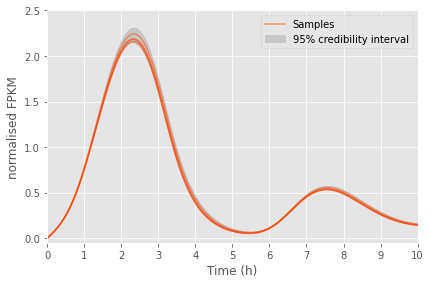

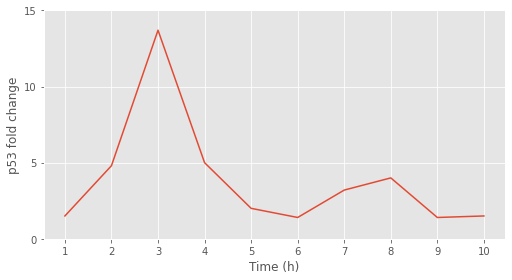

In [15]:
# Plot proteins
p_samples = model.sample_proteins(results, 20)[:,0]
print(p_samples.shape)
plotter.plot_samples(p_samples, [''], 4, color='orangered')
plt.xlim(0, 10)
plt.ylim(-0.05, 2.5)
print(8.51/4.72)
plt.figure(figsize=(4*1.80297, 4))
p = p_samples[-1]
y = [1.5, 4.8, 13.7, 5, 2, 1.4, 3.2, 4, 1.4, 1.5]
# y = y/np.mean(y)*np.mean(p) * 1.75-0.16
# y = scaler.fit_transform(np.expand_dims(y, 0))
plt.plot(t[1:11], y)
plt.ylim(0, 15)
plt.ylabel('p53 fold change')
plt.xlabel('Time (h)')
plt.xticks(np.arange(1, 11))
plt.yticks(np.arange(0, 16, 5))

plt.tight_layout()

## Convergence Plots

In [ ]:
keys = job[0].acceptance_rates.keys()

variables = {key : np.empty((0, T, *job[0].samples[key].get().shape[1:])) for key in keys}

for res in job:
    for key in keys:
        variables[key] = np.append(variables[key], np.expand_dims(res.samples[key].get(), 0), axis=0)

plt.plot(variables['L'][:,-100:].T)

mixes = {key: arviz.convert_to_inference_data(variables[key]) for key in keys}

#### Rhat
Rhat is the ratio of posterior variance and within-chain variance. If the ratio exceeds 1.1 then we consider the chains have not mixed well. As the between-chain variance tends to the within-chain then R tends to 1.

In [ ]:
Rhat = arviz.rhat(mixes['fbar'])

Rhats = np.array([np.mean(arviz.rhat(mixes[key]).x.values) for key in keys])

rhat_df = pd.DataFrame([[*Rhats], [*(Rhats < 1.1)]], columns=keys)

display(rhat_df)